# Laboratorio 4
- Juan Pablo Solis
- Brandon Reyes
- Carlos Valladares

# Task 1 - Preguntas Teoricas
1. Explique con sus propias palabras, qué son los grafos computaciones y cuál es su importancia para el
cálculo de gradientes en aplicaciones como backpropagation.
    - Un grafo computacional es un tipo de grafico el cual su nodo raiz representa la expresión matemática final y cada nodo representa subexpresiones intermedias
2. Detalle cuales son los componentes y pasos que conforman una red neuronal. Con esto en mente, ¿cómo
mejoraría el perceptrón que hizo en el laboratorio pasado?
    - Neuronas: Unidades básicas que procesan información a través de funciones de activación.
    - Capas: Incluyen capa de entrada, capas ocultas y capa de salida.
    - Pesos y sesgos: Factores que determinan la influencia de una neurona en otra.
    - Función de activación: Introduce no linealidad en la red (ReLU, Sigmoide, etc.).
    - Función de costo: Mide la diferencia entre la salida esperada y la obtenida.
    - Algoritmo de optimización: Como el descenso de gradiente para actualizar los pesos.
    - Para mejorar el perceptron añadiendo más capas ocultas y utilizando funciones de activación no lineales
3. Investigue y explique cómo se selecciona el valor K usando el método de la silueta para el algoritmo de K-
Means
    - El método del coeficiente de silueta mide la calidad de los clusters evaluando la similitud de cada punto con su propio cluster y comparándola con otros clusters
    - La ecuacion es S(i)= (b(i)−a(i))/(max(a(i),b(i)))
    - Donde a(i) es la distancia promedio del punto i a los demás puntos de su mismo cluster y b(i) es la menor distancia promedio del punto i a los puntos de otro cluster.
4. ¿Cómo podría ayudarle el PCA a mejorar la calidad de sus clusters cuando se usa K-Means?
    - El PCA ayuda a reducir la dimensionalidad de los datos preservando la varianza más significativa, por lo que puede mejorar significativamente los resultados de K-Means al facilitar la identificación de patrones relevantes en los datos
​


# Task 2.1 K-Means y Segmentación de Clientes de Banco

## 2.1.0 Exploracion e Importacion de datos

In [1]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [2]:
filepath = "bank_transactions.csv"
df = pd.read_csv(filepath)
#Exploracion de datos - Inciso 2.0
print("Distribución inicial de la columna 'status':")
print(df['CustGender'].value_counts())
print("\nVerificacion de datos nulos")
print(df.isnull().sum())
print("\nResumen estadistico de los datos")
print(df.describe())




Distribución inicial de la columna 'status':
CustGender
M    765530
F    281936
T         1
Name: count, dtype: int64

Verificacion de datos nulos
TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

Resumen estadistico de los datos
       CustAccountBalance  TransactionTime  TransactionAmount (INR)
count        1.046198e+06     1.048567e+06             1.048567e+06
mean         1.154035e+05     1.570875e+05             1.574335e+03
std          8.464854e+05     5.126185e+04             6.574743e+03
min          0.000000e+00     0.000000e+00             0.000000e+00
25%          4.721760e+03     1.240300e+05             1.610000e+02
50%          1.679218e+04     1.642260e+05             4.590300e+02
75%          5.765736e+04     2.000100e+05

In [3]:
# Eliminar filas con valores nulos en las columnas especificadas
df = df.dropna(subset=["CustomerDOB", "CustGender", "CustLocation", "CustAccountBalance"])

print("\nVerificacion de datos nulos")
print(df.isnull().sum())


Verificacion de datos nulos
TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64


In [4]:
# Eliminar filas donde el género sea 'T'
df = df[df["CustGender"] != "T"]

label_encoder = LabelEncoder()

# Aplicar Label Encoding a la columna 'CustGender' (M -> 1, F -> 0)
df["CustGender"] = label_encoder.fit_transform(df["CustGender"])

# Aplicar Label Encoding a la columna 'CustLocation'
df["CustLocation"] = label_encoder.fit_transform(df["CustLocation"])



In [5]:

# Seleccionar solo las primeras columnas para mostrar
df_head = df.iloc[:, :5]  # Tomamos las primeras 5 columnas

# Mostrar los datos
df_head


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation
0,T1,C5841053,10/1/94,0,3557
1,T2,C2142763,4/4/57,1,3618
2,T3,C4417068,26/11/96,0,5219
3,T4,C5342380,14/9/73,0,5219
4,T5,C9031234,24/3/88,0,5606
...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,1,5738
1048563,T1048564,C6459278,20/2/92,1,5580
1048564,T1048565,C6412354,18/5/89,1,3367
1048565,T1048566,C6420483,30/8/78,1,9059


# Task 2.2

Entrenando modelos GaussianMixture para diferentes valores de K...
Probando K=2...
Probando K=3...
Probando K=4...
Probando K=5...
Finalizado el cálculo de K óptimo.


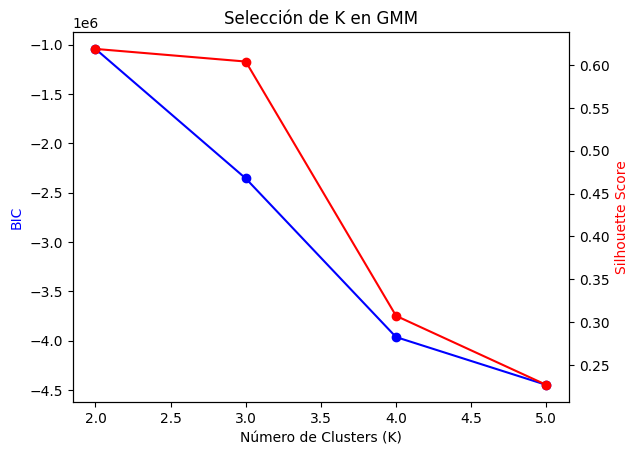

Entrenando modelo final con K=5...
Modelo final entrenado.


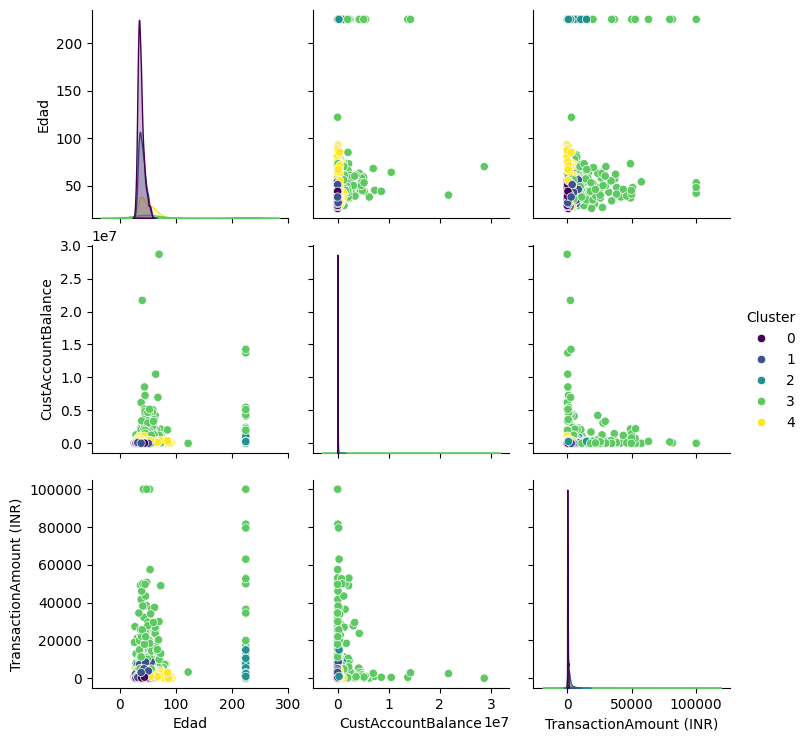

Evaluación: ¿Cuál método fue mejor?


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Cargar datos
file_path = "bank_transactions.csv"
df = pd.read_csv(file_path)

# Preprocesamiento de datos
# Convertir fecha de nacimiento en edad
def calcular_edad(fecha_nac):
    try:
        anio = int(str(fecha_nac).split('/')[-1])
        return 2025 - (1900 + anio) if anio < 100 else 2025 - anio
    except:
        return np.nan

df['Edad'] = df['CustomerDOB'].apply(calcular_edad)

# Eliminar valores nulos
df.dropna(subset=['Edad', 'CustAccountBalance', 'TransactionAmount (INR)'], inplace=True)

# Codificar variables categóricas
label_encoder = LabelEncoder()
df['CustGender'] = label_encoder.fit_transform(df['CustGender'])
df['CustLocation'] = label_encoder.fit_transform(df['CustLocation'])

# Seleccionar variables relevantes
features = ['Edad', 'CustAccountBalance', 'TransactionAmount (INR)']
X = df[features]

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Selección de K usando BIC y Silhouette con muestreo
bic_scores = []
silhouette_scores = []
k_range = range(2, 6)  # Reducido el rango de K para acelerar el proceso

print("Entrenando modelos GaussianMixture para diferentes valores de K...")

for k in k_range:
    print(f"Probando K={k}...")
    gmm = GaussianMixture(n_components=k, random_state=42, max_iter=200, n_init=3, warm_start=True)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    
    # Reducir la muestra para evitar bloqueos en silhouette_score
    try:
        sample_size = min(10000, len(X_scaled))  # Tomar un máximo de 10,000 datos
        silhouette_scores.append(silhouette_score(X_scaled[:sample_size], labels[:sample_size]))
    except:
        silhouette_scores.append(np.nan)
    
print("Finalizado el cálculo de K óptimo.")

# Graficar selección de K
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(k_range, bic_scores, 'bo-', label='BIC')
ax2.plot(k_range, silhouette_scores, 'ro-', label='Silhouette')
ax1.set_xlabel('Número de Clusters (K)')
ax1.set_ylabel('BIC', color='b')
ax2.set_ylabel('Silhouette Score', color='r')
plt.title('Selección de K en GMM')
plt.show()

# Entrenar GMM con el mejor K
best_k = k_range[np.argmin(bic_scores)]
print(f"Entrenando modelo final con K={best_k}...")
gmm = GaussianMixture(n_components=best_k, random_state=42, max_iter=200, n_init=3, warm_start=True)
gmm.fit(X_scaled)
df['Cluster'] = gmm.predict(X_scaled)
print("Modelo final entrenado.")

# Visualizar clusters
sns.pairplot(df.sample(5000), hue='Cluster', vars=features, palette='viridis')  # Reducir datos para visualización
plt.show()

# Comparar con K-Means de Task 2.1 (si se hizo antes)
print("Evaluación: ¿Cuál método fue mejor?")


Sección 1: Importar Librerías
Ejecuta esta celda primero para cargar las librerías necesarias.


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


 Sección 2: Cargar Datos
Esta celda carga el archivo CSV y lo convierte en un DataFrame.

In [25]:
# Cargar datos
file_path = "bank_transactions.csv"  # Asegúrate de que el archivo esté en el mismo directorio o usa la ruta correcta
df = pd.read_csv(file_path)

# Mostrar las primeras filas del dataset
df.head()


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


Sección 3: Preprocesamiento de Datos
Aquí se procesan las variables, incluyendo la conversión de fecha de nacimiento en edad.

In [26]:
# Convertir fecha de nacimiento en edad
def calcular_edad(fecha_nac):
    try:
        anio = int(str(fecha_nac).split('/')[-1])
        return 2025 - (1900 + anio) if anio < 100 else 2025 - anio
    except:
        return np.nan

df['Edad'] = df['CustomerDOB'].apply(calcular_edad)

# Eliminar valores nulos
df.dropna(subset=['Edad', 'CustAccountBalance', 'TransactionAmount (INR)'], inplace=True)

# Mostrar los datos después del preprocesamiento
df.head()


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Edad
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0,31.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0,68.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0,29.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0,52.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5,37.0


Sección 4: Codificación de Variables Categóricas
Transformamos los valores categóricos en numéricos.

In [27]:
label_encoder = LabelEncoder()
df['CustGender'] = label_encoder.fit_transform(df['CustGender'])
df['CustLocation'] = label_encoder.fit_transform(df['CustLocation'])

# Mostrar los datos después de la codificación
df.head()


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Edad
0,T1,C5841053,10/1/94,0,3558,17819.05,2/8/16,143207,25.0,31.0
1,T2,C2142763,4/4/57,1,3619,2270.69,2/8/16,141858,27999.0,68.0
2,T3,C4417068,26/11/96,0,5221,17874.44,2/8/16,142712,459.0,29.0
3,T4,C5342380,14/9/73,0,5221,866503.21,2/8/16,142714,2060.0,52.0
4,T5,C9031234,24/3/88,0,5608,6714.43,2/8/16,181156,1762.5,37.0


Sección 5: Selección y Escalado de Variables
Aquí seleccionamos las variables relevantes y las escalamos.

In [28]:
# Seleccionar variables relevantes
features = ['Edad', 'CustAccountBalance', 'TransactionAmount (INR)']
X = df[features]

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Mostrar las primeras filas de los datos escalados
X_scaled[:5]


array([[-0.44794718, -0.11471756, -0.23496342],
       [ 0.41252356, -0.13309002,  4.02956233],
       [-0.49445911, -0.11465211, -0.16880184],
       [ 0.0404281 ,  0.88811597,  0.07526429],
       [-0.30841138, -0.12783915,  0.02991159]])

Sección 6: Selección de K usando BIC y Silhouette Score
Ejecuta esta celda para encontrar el número óptimo de clusters.

In [30]:
bic_scores = []
silhouette_scores = []
k_range = range(2, 6)  # Reducido el rango de K para acelerar el proceso


print("Entrenando modelos GaussianMixture para diferentes valores de K...")
print("--- NOTA: Esperar que se tarda mucho :) ---")
for k in k_range:
    print(f"Probando K={k}...")
    gmm = GaussianMixture(n_components=k, random_state=42, max_iter=200, n_init=3, warm_start=True)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    
    # Reducir la muestra para evitar bloqueos en silhouette_score
    try:
        sample_size = min(10000, len(X_scaled))  # Tomar un máximo de 10,000 datos
        silhouette_scores.append(silhouette_score(X_scaled[:sample_size], labels[:sample_size]))
    except:
        silhouette_scores.append(np.nan)
    
print("Finalizado el cálculo de K óptimo.")


Entrenando modelos GaussianMixture para diferentes valores de K...
--- NOTA: Esperar que se tarda mucho :) ---
Probando K=2...
Probando K=3...
Probando K=4...
Probando K=5...
Finalizado el cálculo de K óptimo.


Sección 8: Entrenar el Modelo GMM con el Mejor K
Esta celda entrenará el modelo final con el K óptimo.Z

In [31]:
best_k = k_range[np.argmin(bic_scores)]
print(f"Entrenando modelo final con K={best_k}...")

gmm = GaussianMixture(n_components=best_k, random_state=42, max_iter=200, n_init=3, warm_start=True)
gmm.fit(X_scaled)
df['Cluster'] = gmm.predict(X_scaled)

print("Modelo final entrenado.")
print("--- NOTA: Esperar que se tarda mucho :) ---")


Entrenando modelo final con K=5...
Modelo final entrenado.


Sección 9: Visualizar los Clusters
Ejecuta esta celda para ver cómo quedaron los clusters.

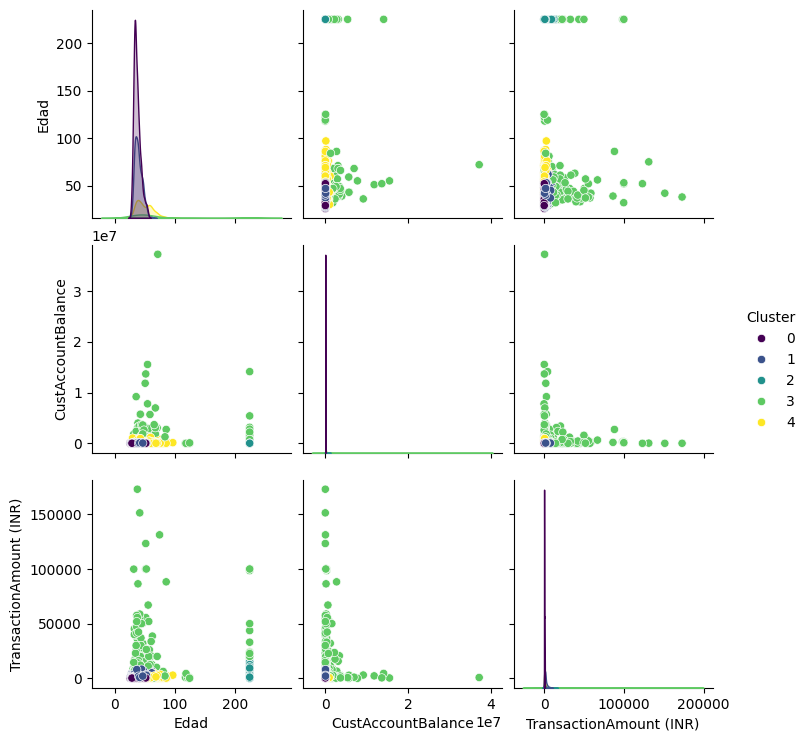

In [32]:
sns.pairplot(df.sample(5000), hue='Cluster', vars=features, palette='viridis')  # Reducir datos para visualización
plt.show()


 Análisis del Resultado
¿Qué indican los gráficos generados?
Los gráficos muestran:

1. Selección de K en GMM

 - BIC (azul) disminuye conforme aumenta K, lo que sugiere que más clusters mejoran el ajuste del modelo.
 - Silhouette Score (rojo) disminuye a partir de K=3, lo que sugiere que más clusters no necesariamente mejoran la separación entre grupos.
 - Conclusión: K=3 o K=4 parecen ser las mejores opciones según el equilibrio entre BIC y Silhouette.
2. Visualización de Clusters

 - Se observa la distribución de clusters en función de Edad, CustAccountBalance y TransactionAmount (INR).
 - Hay agrupaciones visibles, pero algunos clusters parecen solaparse en ciertas dimensiones.
 - Esto puede indicar que GMM está modelando la distribución subyacente, pero aún hay superposición entre los grupos.

1. ¿Qué variables se eligieron para este modelo?
Las variables seleccionadas para el modelo de Mixture Models (GMM) fueron:

Edad (Calculada a partir de CustomerDOB):

Representa el perfil demográfico del cliente.
Puede influir en el comportamiento de transacciones y saldo en la cuenta.
CustAccountBalance (Balance de cuenta del cliente):

Representa la estabilidad financiera y liquidez del cliente.
Es un factor clave para la segmentación en bancos.
TransactionAmount (INR) (Monto de transacción en rupias):

Ayuda a identificar clientes de alto o bajo gasto.
Permite agrupar clientes con patrones de gasto similares.
 -  Razón de la selección:
Estas variables capturan aspectos clave del cliente:

Demográfico (Edad).
Económico (CustAccountBalance).
Comportamiento de gasto (TransactionAmount (INR)).
Esto facilita la segmentación en grupos útiles para estrategias comerciales del banco

2. ¿Qué métrica de desempeño se utilizó y por qué?
Se eligieron dos métricas para evaluar el desempeño del modelo:

Bayesian Information Criterion (BIC)

Evalúa el ajuste del modelo penalizando la complejidad.
Menor BIC indica un mejor balance entre precisión y simplicidad.
Se usa en modelos de mezcla porque ayuda a seleccionar el número óptimo de clusters.
Coeficiente de Silueta

Mide qué tan bien separados están los clusters.
Un valor cercano a 1 indica que los puntos están bien agrupados.
Ayuda a comparar con K-Means, asegurando que los clusters tengan sentido.

 - Razón de la selección:

BIC es ideal para modelos probabilísticos como GMM.
Silhouette Score permite comparar calidad de clusters con K-Means.
Juntas, estas métricas aseguran que el modelo sea preciso y explicativo.


###  Comparación Task 2.1

Agregar texto